<a href="https://colab.research.google.com/github/J-Gann/medfluencer/blob/main/medfluencer_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Medfluencer


In [2]:
# whether to recompute the data or not
recompute = False

In [3]:
%%capture
%pip install -U llama-index-vector-stores-pinecone
%pip install -U llama-index pinecone-client
%pip install -U scikit-learn
%pip install -U umap-learn
%pip install -U transformers sentence-transformers
%pip install anthropic
%pip install llama-index-embeddings-huggingface

In [4]:
from llama_index.vector_stores.pinecone import PineconeVectorStore
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
import numpy as np
from matplotlib.colors import ListedColormap
import os
from anthropic import Anthropic
from collections import Counter
import json
from tqdm.auto import tqdm
import csv
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from google.colab import userdata
import concurrent.futures

ANTHROPIC_API_KEY = userdata.get("ANTHROPIC_API_KEY")
PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

In [5]:
client = Anthropic(api_key=ANTHROPIC_API_KEY)

In [6]:
embed_model = HuggingFaceEmbedding(
    model_name="T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
)

config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [1]:
# Download the git repository to have access to all the data
!git clone https://$GITHUB_TOKEN@github.com/J-Gann/medfluencer.git

Cloning into 'medfluencer'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 223 (delta 106), reused 125 (delta 30), pack-reused 0
Receiving objects: 100% (223/223), 22.94 MiB | 10.09 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Filtering content: 100% (38/38), 13.68 GiB | 131.83 MiB/s, done.


In [7]:
# extract all medical terms from MESH dataset
medical_terms = []
with open("medfluencer/mesh/MH.TXT", "r") as file:
    csv_reader = csv.reader(file, delimiter=";")
    for row in csv_reader:
        medical_terms.append(row[1][1:-1].lower())
medical_terms = set(medical_terms)
medical_terms.remove("es")
medical_terms.remove(
    "kind"
)  # duplicate meaning in en and de => would lead to lots of "child related" deseases later on
medical_terms.remove("seen")
medical_terms.remove("liebe") # occurs very often in comments to indicate support (not really medical topic)

## Analysis of Videos


In [8]:
with open("medfluencer/scraping/videos_scraping.json", "r") as f:
    videos_data = json.load(f)

In [9]:
processed_video_data = []
processed_video_ids = []
for video_id, video in videos_data.items():
   if video["transcription"] is None:
       continue
   if video["description"] is None:
       continue
   if video["title"] is None:
       continue
   processed_video_ids.append(video_id)
   processed_video_data.append(video)

In [10]:
video_transcriptions = [video["transcription"] for video in processed_video_data]
video_descriptions = [video["description"] for video in processed_video_data]
video_titles = [video["title"] for video in processed_video_data]

In [12]:
# compute embeddings for video description, title and whole transcriptions

def get_video_description_embeddings():
   return embed_model.get_text_embedding_batch(video_descriptions, show_progress=True)

def get_video_title_embeddings():
   return embed_model.get_text_embedding_batch(video_titles, show_progress=True)

def get_video_transcription_embeddings():
   return embed_model.get_text_embedding_batch(video_transcriptions, show_progress=True)

if recompute:

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_description = executor.submit(get_video_description_embeddings)
        future_title = executor.submit(get_video_title_embeddings)
        future_transcription = executor.submit(get_video_transcription_embeddings)
        video_description_embeddings = future_description.result()
        video_title_embeddings = future_title.result()
        video_transcription_embeddings = future_transcription.result()

        video_description_embeddings = np.array(video_description_embeddings)
        video_transcription_embeddings = np.array(video_transcription_embeddings)
        video_title_embeddings = np.array(video_title_embeddings)
        processed_video_ids = np.array(processed_video_ids)

        with open("medfluencer/embeddings/video_description_embeddings.npy", "wb") as f:
            np.save(f, video_description_embeddings)

        with open("medfluencer/embeddings/video_transcription_embeddings.npy", "wb") as f:
            np.save(f, video_transcription_embeddings)

        with open("medfluencer/embeddings/video_title_embeddings.npy", "wb") as f:
            np.save(f, video_title_embeddings)

        with open("medfluencer/embeddings/video_ids.npy", "wb") as f:
            np.save(f, processed_video_ids)

In [13]:
with open("medfluencer/embeddings/video_description_embeddings.npy", "rb") as f:
    video_description_embeddings = np.load(f)

with open("medfluencer/embeddings/video_transcription_embeddings.npy", "rb") as f:
    video_transcription_embeddings = np.load(f)

with open("medfluencer/embeddings/video_title_embeddings.npy", "rb") as f:
    video_title_embeddings = np.load(f)

with open("medfluencer/embeddings/video_ids.npy", "rb") as f:
    video_ids = np.load(f)

videos = [videos_data[video_id] for video_id in video_ids]

In [14]:
# Compute UMAP mapping to 2 dimensions

if recompute:
    reducer = umap.UMAP(metric="cosine", n_neighbors=30)
    video_description_embeddings_2d = reducer.fit_transform(video_description_embeddings)

    with open("medfluencer/evaluation/video_description_embeddings_2d.npy", "wb") as f:
        np.save(f, video_description_embeddings_2d)

In [15]:
with open("medfluencer/evaluation/video_description_embeddings_2d.npy", "rb") as f:
   video_description_embeddings_2d = np.load(f)

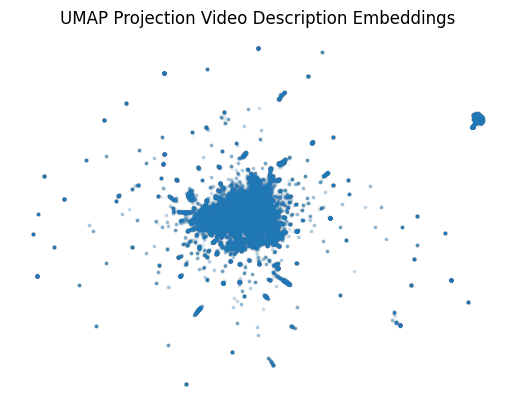

In [16]:
plt.scatter(
    video_description_embeddings_2d[:, 0],
    video_description_embeddings_2d[:, 1],
    marker=".",
    s=10,
    alpha=0.03,
)
plt.title("UMAP Projection Video Description Embeddings")
plt.axis("off")
plt.show()

In [17]:
# Cluster mapped embeddings

if recompute:
    clustering = HDBSCAN(min_cluster_size=50, max_cluster_size=10000).fit_predict(
        video_description_embeddings_2d
    )

In [18]:
# For each cluster compute a label

if recompute:

    unique_clusters = np.unique(clustering)
    n_clusters = len(unique_clusters)
    n_clusters

    terms = {}
    def get_most_frequent_medical_term(transcriptions):
        """Filter out all non-medical terms and return most frequent 15 words"""
        all_medical_words = []
        for transcription in transcriptions:
            words = (
                transcription.lower()
                .replace(",", " ")
                .replace(".", " ")
                .replace("\n", " ")
                .split()
            )
            medical_words = list(filter(lambda x: x in medical_terms, words))
            all_medical_words.extend(medical_words)
        counter = Counter(all_medical_words)
        most_common_word = counter.most_common(15)
        return most_common_word

    # For each cluster infer label from 15 most frequent medical terms using an llm
    for cluster in unique_clusters[1:]:
        cluster_indices = np.where(clustering == cluster)[0]
        transcriptions = [videos[idx]["transcription"] for idx in cluster_indices]
        words = get_most_frequent_medical_term(transcriptions)
        message = client.messages.create(
            max_tokens=4096,
            messages=[
                {
                    "role": "user",
                    "content": "You recieve a list of words along with the number of their occurence in a text. Suggest a medical topic of the underlying text with one or two german words. Only answer with the described topic!\n"
                    + str(words),
                }
            ],
            model="claude-3-5-sonnet-20240620",
            temperature=0,
        )
        terms[cluster] = message.content[0].text

    video_clustering = {
        "clustering": clustering.tolist(),
        "terms": list(terms.values()),
    }

    with open("medfluencer/evaluation/video_clustering.json", "w") as f:
       json.dump(video_clustering, f)

In [55]:
with open("medfluencer/evaluation/video_clustering.json", "r") as f:
    video_clustering_data = json.load(f)

video_clustering = video_clustering_data["clustering"]
video_terms = video_clustering_data["terms"]

In [52]:
def visualize_clusters(text_embeddings, clustering, terms, title):

    unique_clusters = np.unique(clustering)
    n_clusters = len(unique_clusters)


    def generate_distinct_colors(n):
        colors = plt.cm.rainbow(np.linspace(0, 1, n))
        return ListedColormap(colors)


    custom_cmap = generate_distinct_colors(n_clusters)

    fig, ax = plt.subplots(figsize=(40, 40))

    x_min, x_max = np.nanmin(text_embeddings[:, 0]), np.nanmax(text_embeddings[:, 0])
    y_min, y_max = np.nanmin(text_embeddings[:, 1]), np.nanmax(text_embeddings[:, 1])

    for cluster in unique_clusters[1:]:
        embeddings = text_embeddings[clustering == cluster]

        valid_indices = (
            (embeddings[:, 0] >= x_min)
            & (embeddings[:, 0] <= x_max)
            & (embeddings[:, 1] >= y_min)
            & (embeddings[:, 1] <= y_max)
        )

        embeddings = embeddings[valid_indices]

        scatter = ax.scatter(
            embeddings[:, 0],
            embeddings[:, 1],
            marker=".",
            s=20,
            alpha=0.3,
            label=f"cluster {cluster}",
        )

        centroid_x = np.mean(embeddings[:, 0])
        centroid_y = np.mean(embeddings[:, 1])

        # plt.text(centroid_x, centroid_y, str(cluster), fontsize=12, ha='center', va='center')
        plt.text(
            centroid_x,
            centroid_y,
            f"{terms[cluster]}",
            fontsize=12,
            ha="center",
            va="center",
        )

    ax.set_title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

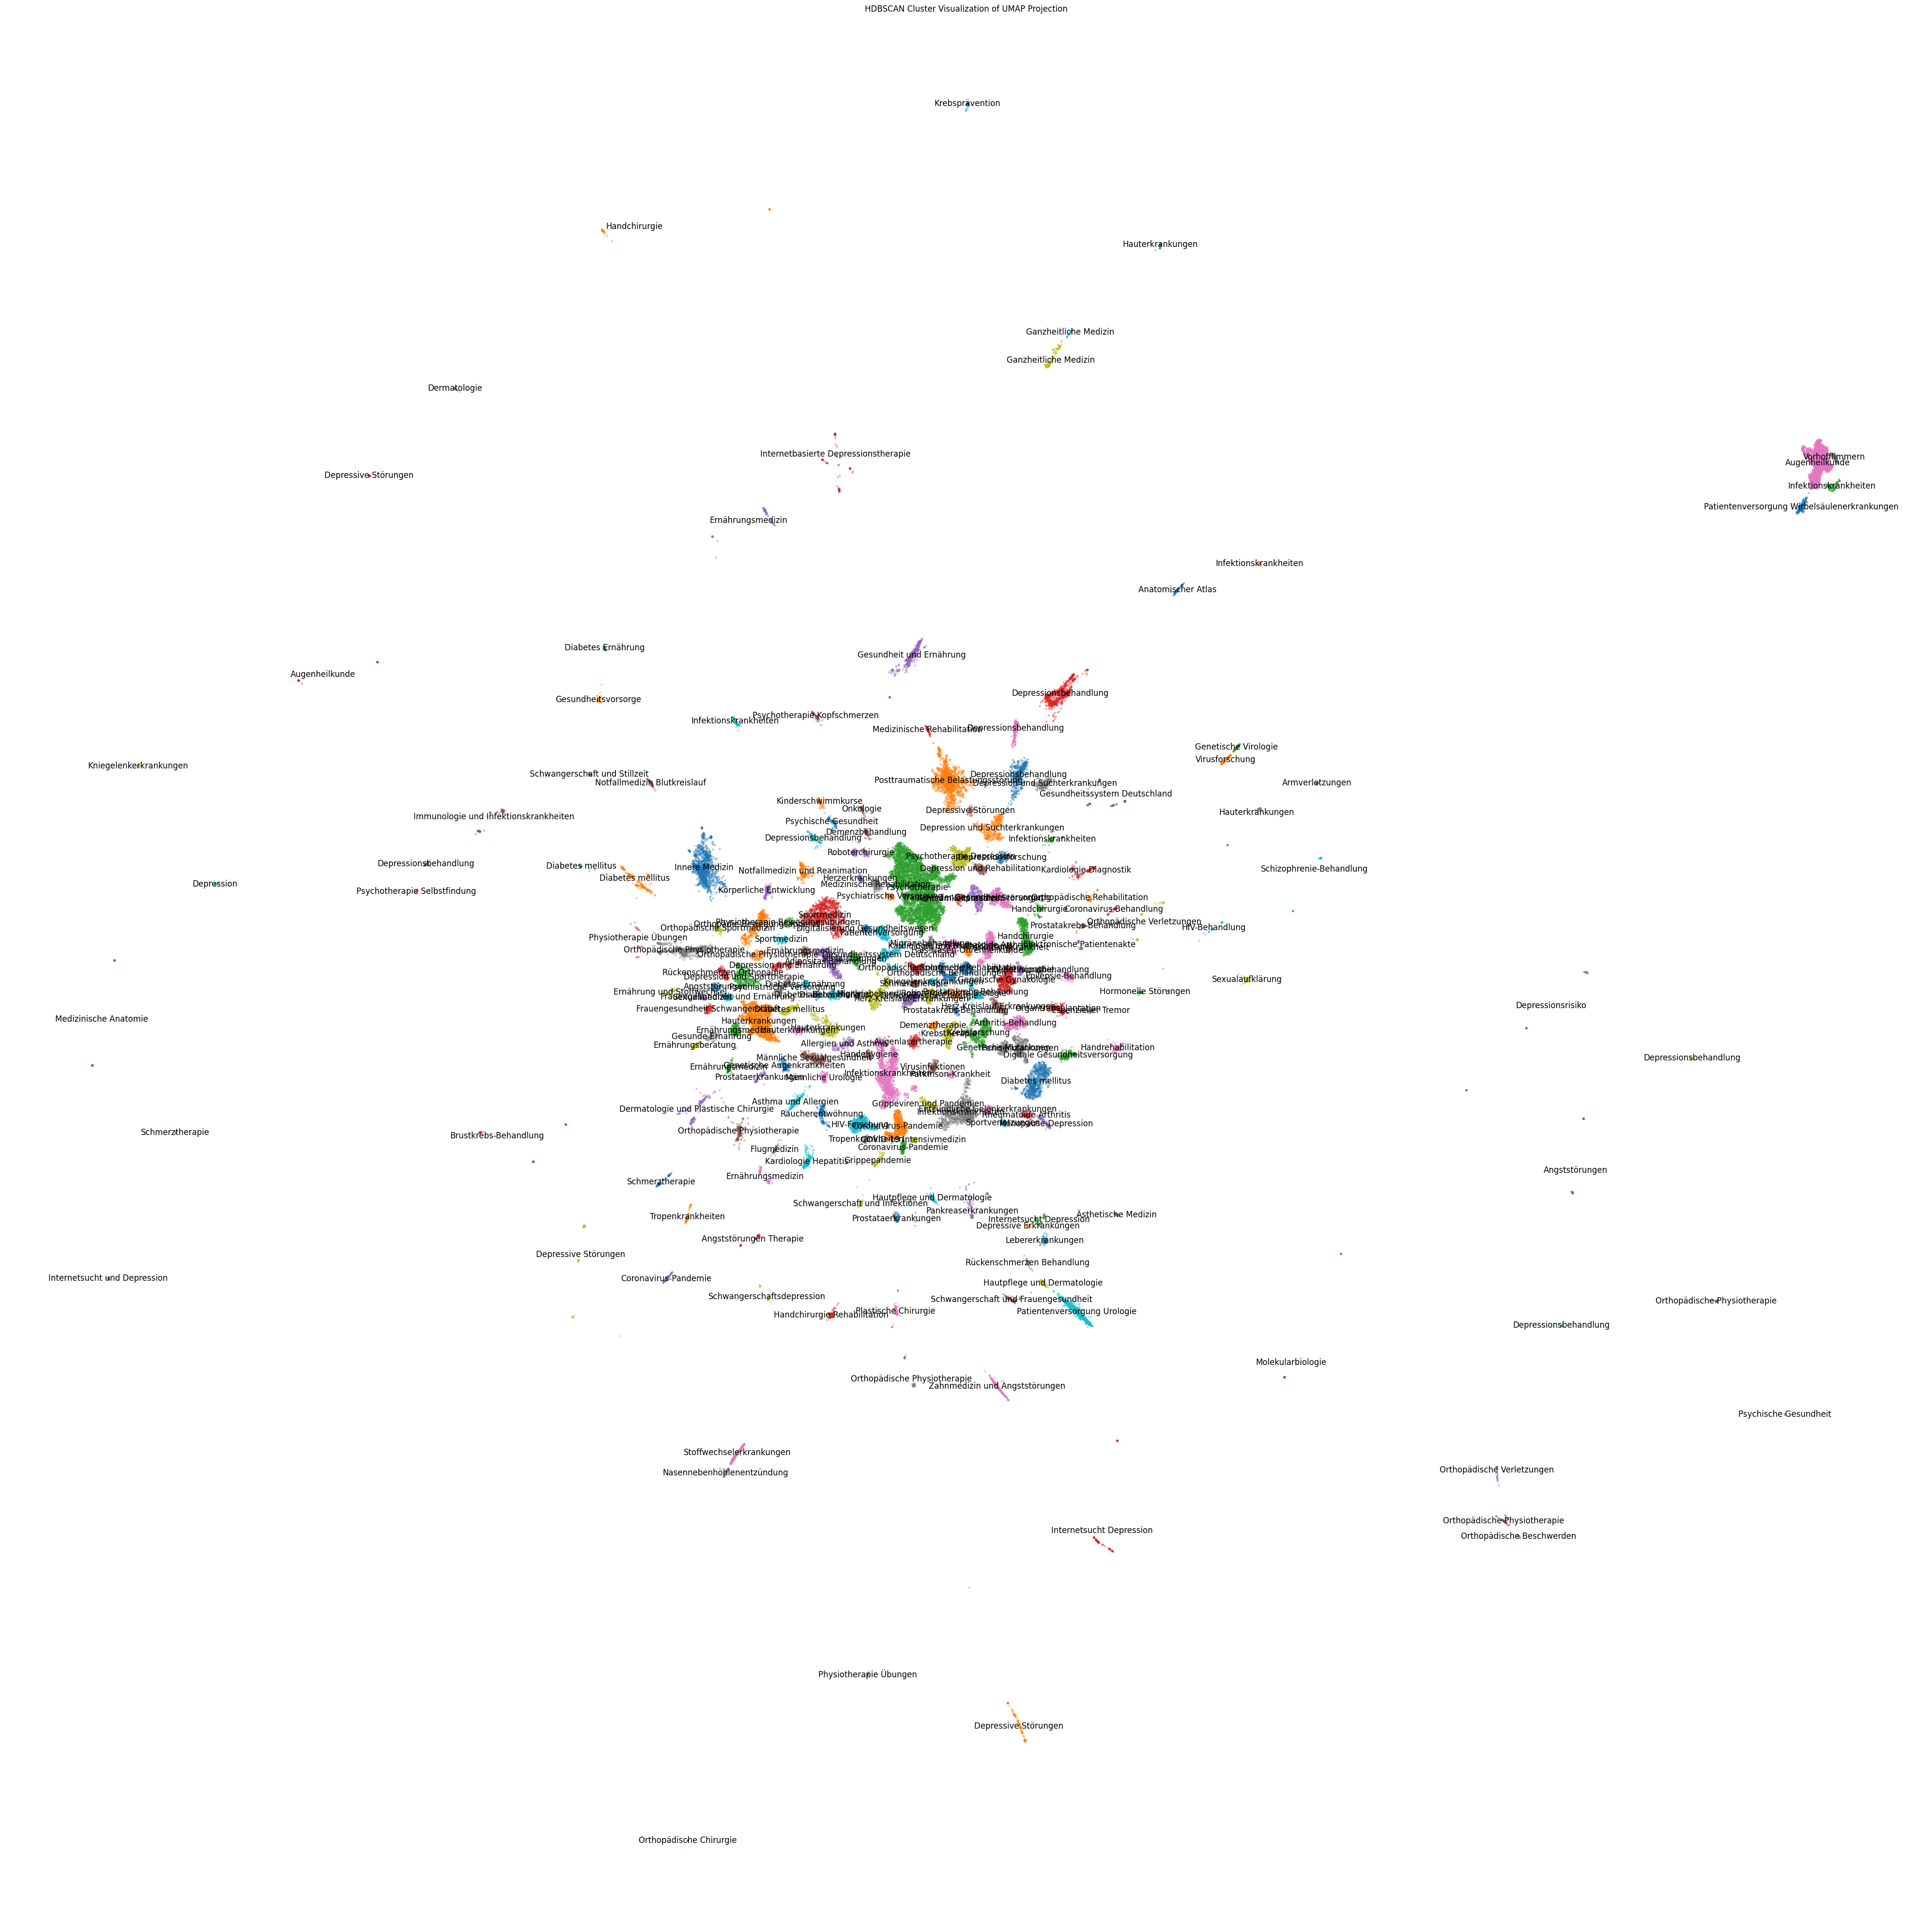

In [56]:
visualize_clusters(
    video_description_embeddings_2d, video_clustering, video_terms, "HDBSCAN Cluster Visualization of UMAP Projection"
)

## Analysis of Comments


In [26]:
with open("medfluencer/scraping/comments_scraping.json", "r") as f:
    comments_data = json.load(f)

In [27]:
comment_texts = [comment["text"] for comment_id, comment in comments_data.items()]

In [31]:
# compute comment embeddings

if recompute:
    comment_embeddings = embed_model.get_text_embedding_batch(
        comment_texts, show_progress=True
    )

    # save embeddings in 4 parts (to not exceed GitHub LFS file size limit)

    num_parts = 4
    split_arrays = np.array_split(comment_embeddings, num_parts)
    filenames = []
    for i, split_array in enumerate(split_arrays):
        filename = f"medfluencer/embeddings/comment_embeddings_part_{i + 1}.npy"
        with open(filename, "wb") as f:
            np.save(f, split_array)
        filenames.append(filename)

In [32]:
num_parts = 4
data = []
for i in range(num_parts):
    filename = f"medfluencer/embeddings/comment_embeddings_part_{i + 1}.npy"
    with open(filename, "rb") as f:
        data_part = np.load(f)
        data.append(data_part)

comment_embeddings = np.concatenate(data)

In [33]:
# compute mapping of comment embeddings

if recompute:
    reducer = umap.UMAP(metric="cosine", n_neighbors=30)
    comment_embeddings_2d = reducer.fit_transform(comment_embeddings)

In [34]:
with open("medfluencer/evaluation/comment_embeddings_2d.npy", "rb") as f:
    comment_embeddings_2d = np.load(f)

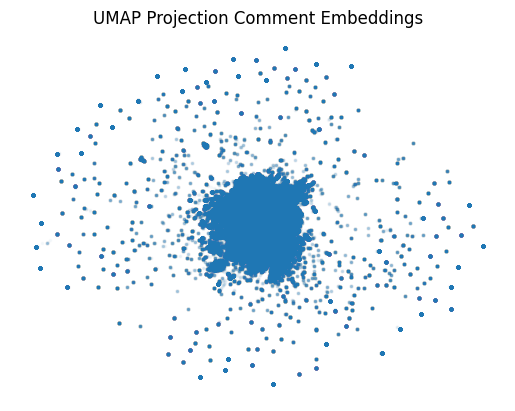

In [35]:
plt.scatter(
    comment_embeddings_2d[:, 0],
    comment_embeddings_2d[:, 1],
    marker=".",
    s=10,
    alpha=0.03,
)
plt.title("UMAP Projection Comment Embeddings")
plt.axis("off")
plt.show()

In [37]:
# compute clustering of mapped comment embeddings

if recompute:
    clustering = HDBSCAN(min_cluster_size=50, max_cluster_size=10000).fit_predict(
        comment_embeddings_2d
    )
    with open("medfluencer/evaluation/comment_embeddings_2d_clustering.npy", "wb") as f:
        np.save(f, clustering)

In [38]:
with open("medfluencer/evaluation/comment_embeddings_2d_clustering.npy", "rb") as f:
    clustering = np.load(f)

In [43]:
with open ("medfluencer/evaluation/german_filler_words.json", "r") as f:
    remove_list_german = list(set(json.load(f)))

with open ("medfluencer/evaluation/english_filler_words.json", "r") as f:
    remove_list_english = list(set(json.load(f)))

In [44]:
all_filler_words = remove_list_english + remove_list_german + ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", ",", ".", "-", "#", "+", "*", "~", "<", ">", ";", ":", "&", "%", ")", "(", "{", "}", "[", "["] + [str(x) for x in range(100)]

In [47]:
# todo compute a label for each comment cluster

if recompute:
    terms = {}

    def get_most_frequent_medical_term(transcriptions):
        all_medical_words = []
        for transcription in transcriptions:
            words = (
                transcription.lower()
                .replace(",", " ")
                .replace(".", " ")
                .replace("\n", " ")
                .replace("!", " ")
                .replace("?", " ")
                .split()
            )
            words = list(filter(lambda x: x not in all_filler_words, words))
            all_medical_words.extend(words)

        counter = Counter(all_medical_words)
        most_common_word = counter.most_common(15)
        return most_common_word


    for cluster in unique_clusters[1:]:
        cluster_indices = np.where(clustering == cluster)[0]
        transcriptions = [comment_texts[idx] for idx in cluster_indices]
        words = get_most_frequent_medical_term(transcriptions)

        total_count = sum([word[1] for word in words])

        if words != [] and total_count > 50:
            message = client.messages.create(
                max_tokens=4096,
                messages=[
                    {
                        "role": "user",
                        "content": """You recieve a list of most frequent words originating from comments of a YouTube video along with the number of their occurence.
                                        Create a german label which describes the shared meaning of the words as concise and precise as possible.
                                        If you want to answer with two words, select only one of them.
                                        In order to find the most suitable label, imagine what a user would want to express in his comment using the given words.
                                        Only answer with the content of the label.
                                        If there are only filler words like 'der', 'die', 'das', 'und' or similar, answer with 'unbekannt'."""
                        + str(words),
                    }
                ],
                model="claude-3-5-sonnet-20240620",
                temperature=0,
            )
            terms[cluster] = message.content[0].text
        else:
            terms[cluster] = ""

    remove = []

    filtered_terms  = {}
    for cluster, term in terms.items():
        if term.lower() == "unbekannt":
            filtered_terms[cluster] = ""
        else:
            filtered_terms[cluster] = term

    comment_clustering = {
        "clustering": clustering.tolist(),
        "terms": list(filtered_terms.values()),
    }

    with open("medfluencer/evaluation/comment_clustering.json", "w") as f:
        json.dump(comment_clustering, f)

In [57]:
with open("medfluencer/evaluation/comment_clustering.json", "r") as f:
   comment_clustering_data = json.load(f)

clustering_comments = comment_clustering_data["clustering"]
filtered_terms_comments = comment_clustering_data["terms"]

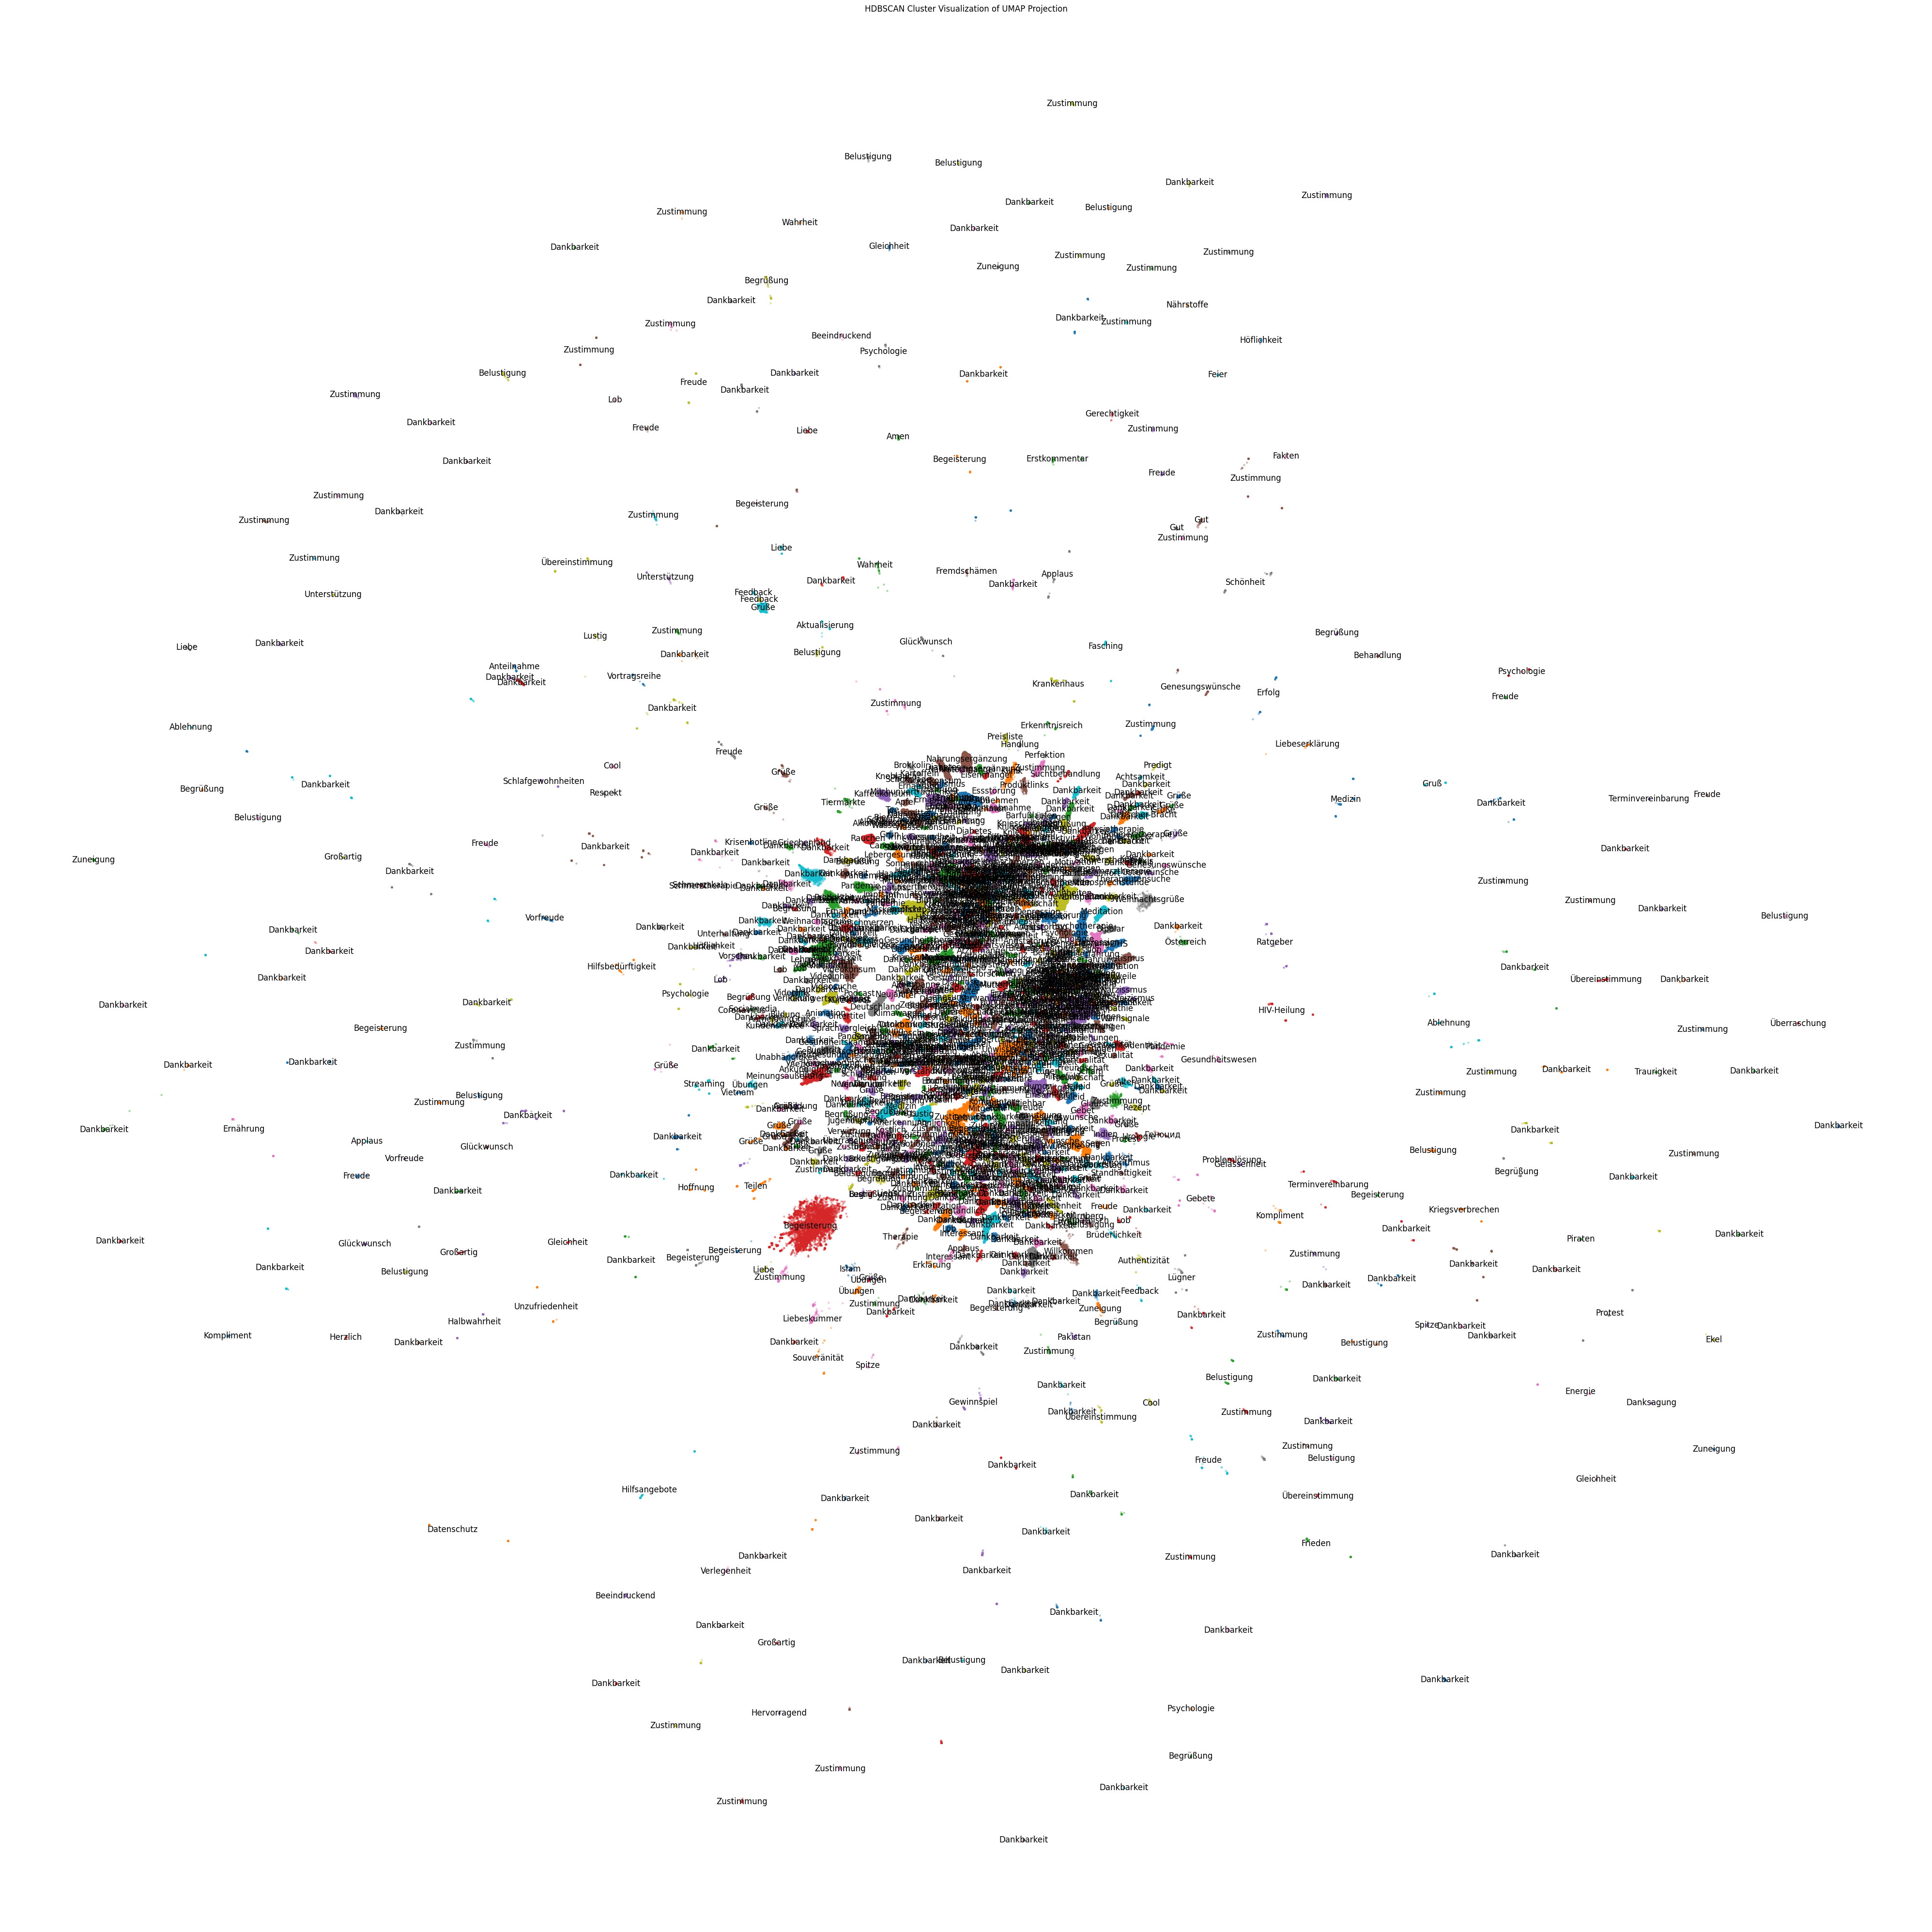

In [61]:
# To get a less cluttered visualization, modify the plot to zoom in
visualize_clusters(
    comment_embeddings_2d, clustering_comments, filtered_terms_comments, "HDBSCAN Cluster Visualization of UMAP Projection"
)